In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-

In [4]:
(X_train, _), (_, _) = mnist.load_data()

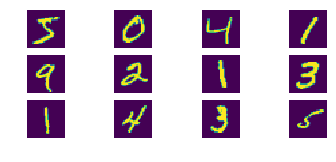

In [3]:
for i in range(12):
    plt.subplot(5,4,i+1)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

In [1]:
in_shape = (28,28,1)
disc = Sequential()
disc.add(Conv2D(64, (3,3), padding = 'same', input_shape = in_shape)) #28*28*64
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.5))
disc.add(BatchNormalization(momentum=0.8))
disc.add(Conv2D(64, (3,3), padding = 'same'))   #28*28*64
disc.add(LeakyReLU(alpha = 0.2))

disc.add(Dropout(0.5))
disc.add(Flatten())     #50176
disc.add(Dense(512))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(256))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(128))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(1, activation = 'sigmoid'))

opt = Adam(lr = 0.0002)
disc.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')

disc.summary()

NameError: name 'Sequential' is not defined

In [2]:
n_nodes = 7*7*256
gen = Sequential()
gen.add(Dense(n_nodes, input_shape = (100,)))  
gen.add(LeakyReLU(alpha = 0.3))
gen.add(Reshape((7,7,256)))  #7*7*256
gen.add(Conv2DTranspose(128, (2,2), padding = 'same'))  #7*7*128
gen.add(LeakyReLU(alpha = 0.3))
gen.add(BatchNormalization(momentum=0.8))
gen.add(Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')) #14*14*64
gen.add(LeakyReLU(alpha = 0.3))
gen.add(Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')) #28*28*64
gen.add(LeakyReLU(alpha = 0.3))
gen.add(BatchNormalization(momentum=0.8))

gen.add(Conv2D(1, (2,2), padding = 'same', activation = 'sigmoid')) #28*28*1

opt = Adam(lr = 0.0002)
gen.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')

gen.summary()

NameError: name 'Sequential' is not defined

In [ ]:
noise = tf.random.normal([1,100])
gen_img = gen(noise, training = False)

In [ ]:
plt.imshow(gen_img[0,:,:,0])

In [ ]:
desc = disc(gen_img)

In [ ]:
print(desc)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def disc_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    total_loss = real_loss+fake_loss
    return total_loss

def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=gen,
                                 discriminator=disc)

In [17]:
model = Sequential()
model.add(gen)
model.add(disc)
opt = Adam(lr = 0.0002)
model.compile(loss = 'binary_crossentropy', optimizer = opt)

In [7]:
from numpy import zeros,ones, expand_dims
from numpy.random import randint, randn

In [5]:
X_train.shape[0]

60000

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

In [9]:
def gen_latent_points(dims, n_samples):
    x_input = randn(dims*n_samples)
    x_input = x_input.reshape(n_samples, dims)
    return x_input

In [10]:
def generate_fake_samples(gen, dims, n_samples):
    x_input = gen_latent_points(dims, n_samples)
    X = gen.predict(x_input)
    y = zeros((n_samples,1))
    return X,y

In [11]:
dims = 100
X_train = expand_dims(X_train, axis = 3)
X_train = X_train/255.0

In [19]:
def train(gen, disc, model, dataset, dims, epoch = 5, n_batch = 128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(epoch):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            with tf.device('/gpu:0'):
                d_loss1, d_acc1 = disc.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(gen, dims, half_batch)
            with tf.device('/gpu:0'):
                d_loss2, d_acc2 = disc.train_on_batch(X_fake, y_fake)
            X_gan = gen_latent_points(dims, n_batch)
            y_gan  =ones((n_batch, 1))
            with tf.device('/gpu:0'):
                g_loss = model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.10f, acc1=%.10f, d2=%.10f acc2=%.10f gl=%.10f ' % 
                  (i+1, j+1, bat_per_epo, d_loss1, d_acc1, d_loss2, d_acc2, g_loss,))
        model.save('generator.h5')

In [20]:
train(gen, disc, model, X_train, dims)

ResourceExhaustedError: OOM when allocating tensor with shape[512,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill] name: Adam/dense_8/kernel/v/Initializer/zeros/

In [ ]:
(_, _), (X_test, _) = mnist.load_data()

In [ ]:
def generate_and_save_images(model, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')
    plt.savefig('image_generated.png')
    plt.show()

In [ ]:
generate_and_save_images(gen, noise)

In [ ]:
X_test = X_test/255.0
X_test = expand_dims(X_test, axis = 3)
X_test = X_test.astype('float32')

In [ ]:
noise = np.random.normal(0, 1, (5 * 5, 100))
gen_imgs = gen.predict(noise)

In [ ]:
noise.shape

In [ ]:
plt.imshow(gen_imgs[7].reshape(28,28))

In [ ]:
noise

In [ ]:
model.save('gan_complete')
gen.save('gan_gen')
disc.save('gan_disc')

In [ ]:
gen = load_model('gan_gen')
disc = load_model('gan_disc')

In [ ]:
def save_imgs(generator):
    r, c = 5, 5
    epoch = 5
    batch = 28
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [ ]:
save_imgs(gen)

In [ ]:
disc.trainable = False
model = Sequential()
model.add(gen)
model.add(disc)
opt = Adam(lr = 0.0002)
model.compile(loss = 'binary_crossentropy', optimizer = opt)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)
opt = Adam(lr = 0.0002, beta_1 = 0.4)
disc.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')
gen.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')

In [ ]:
def train(gen, disc, model, dataset, dims, epoch = 10, n_batch = 128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(epoch):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            with tf.device('/gpu:0'):
                d_loss1, d_acc1 = disc.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(gen, dims, half_batch)
            with tf.device('/gpu:0'):
                d_loss2, d_acc2 = disc.train_on_batch(X_fake, y_fake)
            X_gan = gen_latent_points(dims, n_batch)
            y_gan  =ones((n_batch, 1))
            with tf.device('/gpu:0'):
                g_loss = model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, acc1=%.3f, d2=%.3f acc2=%.3f gl=%.3f ' % 
                  (i+1, j+1, bat_per_epo, d_loss1, d_acc1, d_loss2, d_acc2, g_loss,))
        model.save('generator.h5')

In [ ]:
train(gen, disc, model, X_train, dims)

In [ ]:
def train(gen, disc, model, dataset, dims, epoch = 5, n_batch = 128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(epoch):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            with tf.device('/gpu:0'):
                d_loss1, d_acc1 = disc.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(gen, dims, half_batch)
            with tf.device('/gpu:0'):
                d_loss2, d_acc2 = disc.train_on_batch(X_fake, y_fake)
            X_gan = gen_latent_points(dims, n_batch)
            y_gan  =ones((n_batch, 1))
            with tf.device('/gpu:0'):
                g_loss = model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.10f, acc1=%.10f, d2=%.10f acc2=%.10f gl=%.10f ' % 
                  (i+1, j+1, bat_per_epo, d_loss1, d_acc1, d_loss2, d_acc2, g_loss,))
        model.save('generator.h5')


In [ ]:
train(gen, disc, model, X_train, dims)

In [ ]:
noise = np.random.normal(0, 1, (5 * 5, 100))
gen_imgs = gen.predict(noise)

noise.shape

In [ ]:
for i in range(10):
    plt.subplot(4,3, i+1)
    plt.imshow(gen_imgs[i].reshape(28,28))
plt.show()